In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found, model running on CPU")
import tensorflow_addons as tfa
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import math
import seaborn as sns
tf.random.set_seed(42)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def record_parser(example, image_size=224):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image.set_shape([image_size, image_size, 3])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename, image_size=224):
  base_path = 'datasets/'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parser = lambda x, size=image_size: record_parser(x, image_size=size)
  parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

batch_size = 64

@tf.function
def apply_random_scaling(image, minval=-.02, maxval=.02):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    
    return output, param

def apply_random_shearing(image, minval=-5., maxval=5.):
    #param = tf.random.uniform([], minval=tf.math.atan(minval/image.shape[1]), maxval=tf.math.atan(maxval/image.shape[1]))
    #param = tf.random.uniform([], minval=tf.math.atan(), maxval=tf.math.atan(maxval/image.shape[1]))
    param = np.random.uniform(low=minval, high=maxval)
    output = warp(np.array(image), AffineTransform(shear=np.arctan(param/image.shape[1])).inverse)
    return output, param
@tf.function
def apply_random_rotation(image, minval=-7, maxval=7):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
    return output, param


@tf.function
def apply_tta(image, labels, magnitude=tf.constant(1.0)):
    
    if magnitude <= 0.0:
        return {'x': [image]*10, 'y': [labels]*10, 'method': ['NO_TTA']*10, 'param':[0.0]*10}
    
    scaling_min=-.02*magnitude
    scaling_max=.02*magnitude
    rotation_min=-7*magnitude
    rotation_max=7*magnitude
    augmented_samples = {'x': list(), 'y': list(), 'method': list(), 'param':list()}
    
    output = image
    param = tf.constant(0.0)
    
    # NO-FLIP
    augmented_samples['x'].append(image)
    augmented_samples['y'].append(labels)
    augmented_samples['param'].append(param)
    augmented_samples['method'].append('NOFLIP/ORIGINAL')
        
    # NO-FLIP + ROTATION
    for i in range(1, 3):
        param = tf.random.uniform([], minval=rotation_min, maxval=rotation_max)
        output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('NOFLIP/ROTATION')    
    
    # NO-FLIP + SCALING
    for i in range(1, 3):
        param = tf.random.uniform([], minval=scaling_min, maxval=scaling_max)
        source_size = image.shape
        target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
        output = tf.image.resize_with_crop_or_pad(tf.image.resize(image, target_size), source_size[0], source_size[1])
        
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('NOFLIP/SCALING') 
    
    flip = tf.image.flip_left_right(image)
    param = tf.constant(0.0)
    
    # NO-FLIP
    augmented_samples['x'].append(flip)
    augmented_samples['y'].append(labels)
    augmented_samples['param'].append(param)
    augmented_samples['method'].append('FLIP/ORIGINAL')
        
    # NO-FLIP + ROTATION
    for i in range(1, 3):
        param = tf.random.uniform([], minval=rotation_min, maxval=rotation_max)
        output = tfa.image.rotate(flip, param*math.pi/180.0, interpolation='BILINEAR')
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('FLIP/ROTATION')    
    
    # NO-FLIP + SCALING
    for i in range(1, 3):
        param = tf.random.uniform([], minval=scaling_min, maxval=scaling_max)
        source_size = flip.shape
        target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
        output = tf.image.resize_with_crop_or_pad(tf.image.resize(flip, target_size), source_size[0], source_size[1])
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('FLIP/SCALING') 
    
    return augmented_samples
    
    
def load_dataset_with_tta(filename, image_size=224, tta_magnitude=1.0):
    base_path = 'datasets/'
    full_path = os.path.join(base_path,filename)
    dataset = tf.data.TFRecordDataset(full_path)
    parser = lambda x, size=image_size: record_parser(x, image_size=size)
    parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    custom_tta = lambda x, y: apply_tta(x, y, magnitude=tf.constant(tta_magnitude))
    parsed_dataset = parsed_dataset.map(custom_tta,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    return parsed_dataset



train_dataset = make_dataset('training_cropped.tfrecords').batch(1024).prefetch(1)
val_dataset = make_dataset('validation_cropped.tfrecords').batch(1024).prefetch(1)
#train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)

# UNCOMMENT TO ENABLE TRAINING
conditional_train_dataset = make_dataset('conditional_training.tfrecords').batch(1024).prefetch(1)
#val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
test_dataset = make_dataset('test_set_cropped.tfrecords').batch(1024).prefetch(1)



# TODO: Since we cannot convert the full pipeline to tensorflow (due to shearing depending on Skimage), the make tta dataset will:
# 1) Compute the dataset if not already present at the given path (using the classical for structure)
# 2) Load the dataset from npy files as a tensorflow dataset

In [2]:
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

In [3]:
train_labels = pd.DataFrame(columns=dummy_labels)
for x, y in train_dataset:
    train_labels = train_labels.append(pd.DataFrame(y.numpy(), columns=dummy_labels), ignore_index=True)

In [4]:
cond_train_labels = pd.DataFrame(columns=dummy_labels)
for x, y in conditional_train_dataset:
    cond_train_labels = cond_train_labels.append(pd.DataFrame(y.numpy(), columns=dummy_labels), ignore_index=True)

In [5]:
val_train_labels = pd.DataFrame(columns=dummy_labels)
for x, y in val_dataset:
    val_train_labels = val_train_labels.append(pd.DataFrame(y.numpy(), columns=dummy_labels), ignore_index=True)

In [6]:
test_labels = pd.DataFrame(columns=dummy_labels)
for x, y in test_dataset:
    test_labels = test_labels.append(pd.DataFrame(y.numpy(), columns=dummy_labels), ignore_index=True)

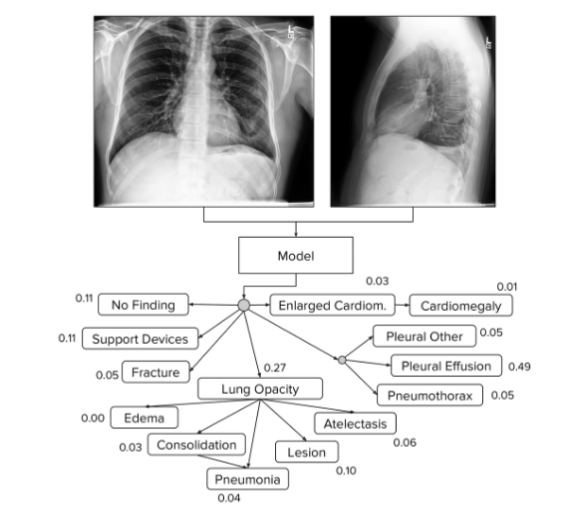

In [15]:
def generate_condition(dataframe):
    cardiomegaly = (dataframe['Enlarged Cardiomediastinum']<1.0) & (dataframe['Cardiomegaly'] > 0.)
    edema = (dataframe['Lung Opacity']<1.0) & (dataframe['Edema'] > 0.)
    lesion = (dataframe['Lung Opacity']<1.0) & (dataframe['Lung Lesion'] > 0.)
    atelectasis = (dataframe['Lung Opacity']<1.0) & (dataframe['Atelectasis'] > 0.)
    consolidation = (dataframe['Lung Opacity']<1.0) & (dataframe['Consolidation'] > 0.)
    pneumonia = ((dataframe['Lung Opacity']<1.0) & (dataframe['Pneumonia'] > 0.)) | ((dataframe['Consolidation']<1.0) & (dataframe['Pneumonia'] > 0.))
    filter_ = cardiomegaly | edema | lesion | atelectasis | consolidation | pneumonia
    
    sums = {'cardiomegaly': cardiomegaly.sum(),
     'edema': edema.sum(),
     'lesion': lesion.sum(),
     'atelectasis': atelectasis.sum(),
     'consolidation': consolidation.sum(),
     'pneumonia': pneumonia.sum()
    }
    
    return filter_, sums
    

def check_condition(dataframe):
    report = pd.DataFrame()
    filter_, sums = generate_condition(dataframe)
    sums.update({'total_violations': len(dataframe.loc[filter_]), 'dataset_length':len(dataframe)})
    report = report.append(sums, ignore_index=True)
    return report

In [16]:
report = pd.DataFrame()
report = report.append(check_condition(test_labels))
report = report.append(check_condition(train_labels))
report = report.append(check_condition(cond_train_labels))
report = report.append(check_condition(val_train_labels))
report['dataset'] = ['test', 'train', 'cond_train', 'validation']
report.to_csv('unconditional_check.csv')

In [9]:
{'a':3}.update({'b':4})

In [14]:
report

,atelectasis,cardiomegaly,consolidation,dataset_length,edema,lesion,pneumonia,total_violations,dataset
0,0.0,0.0,0.0,202.0,0.0,0.0,0.0,0.0,test
0,25009.0,27972.0,15962.0,189116.0,26549.0,3366.0,19266.0,82700.0,train
0,22688.0,14080.0,14401.0,90952.0,24452.0,2959.0,4452.0,51835.0,cond_train
0,276.0,285.0,184.0,1911.0,291.0,26.0,158.0,836.0,validation
